In [2]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.metrics import CategoricalAccuracy


from data_processing import segment_spectrum_batch
from RamanNet_model import RamanNet

In [1]:
import sys
sys.path.append('./RamanNet/source/codes/')  # Adjust this to your path
from RamanNet_model2 import RamanNet

from train_model import train_model

2024-08-21 20:47:47.490041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


In [4]:
import numpy as np


X_fn = './data/X_reference.npy'
y_fn = './data/y_reference.npy'

X = np.load(X_fn)
y = np.load(y_fn)

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (60000, 1000), y shape: (60000,)


In [5]:
from tensorflow.keras.utils import to_categorical


Y_onehot = to_categorical(y)


In [6]:
from sklearn.model_selection import train_test_split


X_train, X_val, Y_train_onehot, Y_val_onehot = train_test_split(X, Y_onehot, test_size=0.1, random_state=42)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"Y_train_onehot shape: {Y_train_onehot.shape}, Y_val_onehot shape: {Y_val_onehot.shape}")


X_train shape: (54000, 1000), X_val shape: (6000, 1000)
Y_train_onehot shape: (54000, 30), Y_val_onehot shape: (6000, 30)


Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.8551 - embedding_loss: 0.9313 - classification_loss: 0.7789 - embedding_categorical_accuracy: 0.0060 - classification_categorical_accuracy: 0.7631
Epoch 1: val_loss improved from inf to 0.90341, saving model to best_model.h5


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


211/211 [==============================] - 184s 507ms/step - loss: 0.8551 - embedding_loss: 0.9313 - classification_loss: 0.7789 - embedding_categorical_accuracy: 0.0060 - classification_categorical_accuracy: 0.7631 - val_loss: 0.9034 - val_embedding_loss: 0.8605 - val_classification_loss: 0.9464 - val_embedding_categorical_accuracy: 0.0303 - val_classification_categorical_accuracy: 0.6985 - lr: 0.0010
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.5985 - embedding_loss: 0.8740 - classification_loss: 0.3229 - embedding_categorical_accuracy: 0.0066 - classification_categorical_accuracy: 0.8902
Epoch 2: val_loss improved from 0.90341 to 0.55136, saving model to best_model.h5
211/211 [==============================] - 98s 466ms/step - loss: 0.5985 - embedding_loss: 0.8740 - classification_loss: 0.3229 - embedding_categorical_accuracy: 0.0066 - classification_categorical_accuracy: 0.8902 - val_loss: 0.5514 - val_embedding_loss: 0.7914 - val_classification_loss: 0.

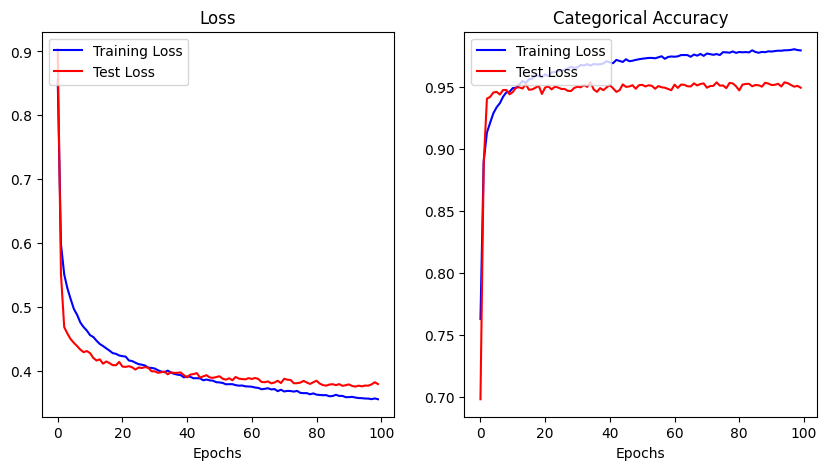

In [7]:

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from RamanNet_model2 import RamanNet
from data_processing import segment_spectrum_batch


w_len = 10
dw = 5
epochs = 100
model_path = 'best_model.h5'

# Train the model
mdl, training_history = train_model(
    X_train=X_train,
    Y_train_onehot=Y_train_onehot,
    X_val=X_val,
    Y_val_onehot=Y_val_onehot,
    w_len=w_len,
    dw=dw,
    epochs=epochs,
    model_path=model_path,
    plot=True
)


In [8]:
# Load the best model (if needed)
from tensorflow.keras.models import load_model

# Load the custom loss function
custom_objects = {"Addons>TripletSemiHardLoss": tfa.losses.TripletSemiHardLoss}
model = load_model(model_path, custom_objects=custom_objects)

# Make predictions
X_test_segmented = segment_spectrum_batch(X_val, w_len, dw)
y_pred = model.predict(X_test_segmented)

y_pred_classes = np.argmax(y_pred[1], axis=1)

# Evaluate the model on the validation data
from sklearn.metrics import confusion_matrix, accuracy_score
conf_matrix = confusion_matrix(np.argmax(Y_val_onehot, axis=1), y_pred_classes)
acc = accuracy_score(np.argmax(Y_val_onehot, axis=1), y_pred_classes)

print(f'Validation Accuracy: {acc * 100:.2f}%')

188/188 [==============================] - 12s 15ms/step
Validation Accuracy: 95.27%
